# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import tifffile as tiff

## Load test features

In [106]:
# DATOS_train
datos_test = pd.read_csv("data/DATOS_test.csv")
datos_test.head()
datos_test.shape

(1329, 2)

In [3]:
path_feats = "data/test_features/content/test_features/"

In [4]:
feats = []
for n in range(len(datos_test)):
    path_feat = datos_test.iloc[n].feature_image
    feat = tiff.imread(path_feats + path_feat)
    
    feats.append(feat)
    
feats = np.array(feats)

In [5]:
feats.shape

(1329, 128, 128, 10)

In [6]:
feats.min(), feats.max()

(-3.4028235e+38, 1.0)

## Prepocess Features

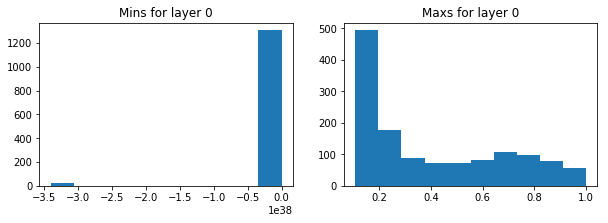

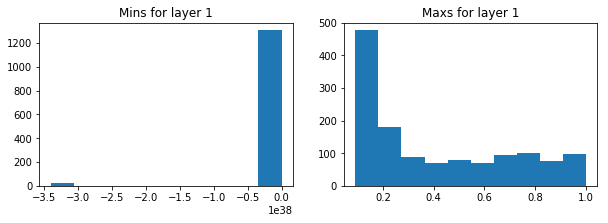

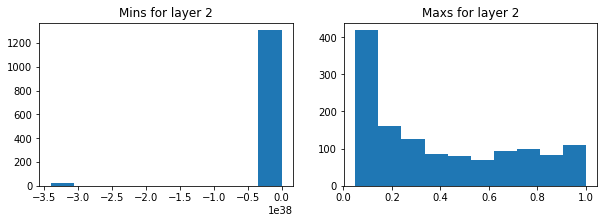

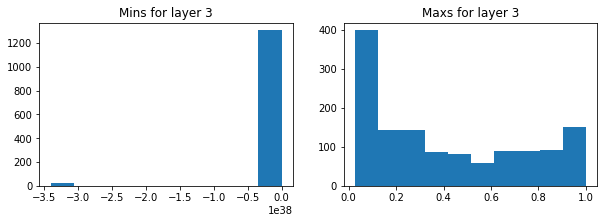

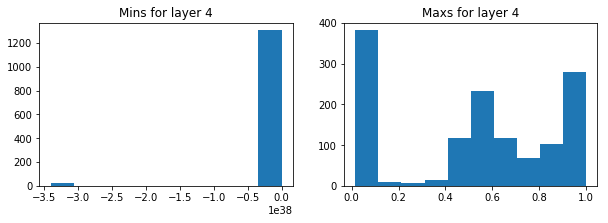

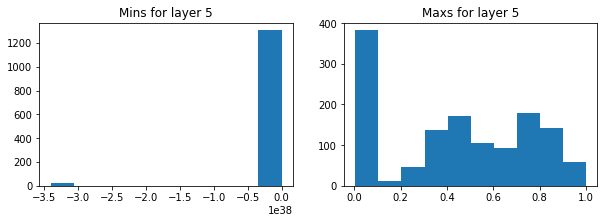

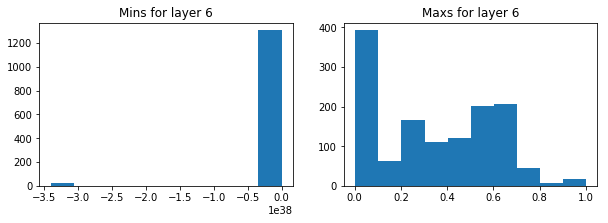

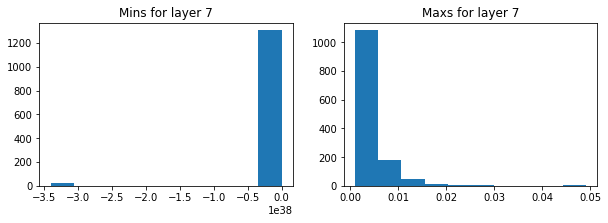

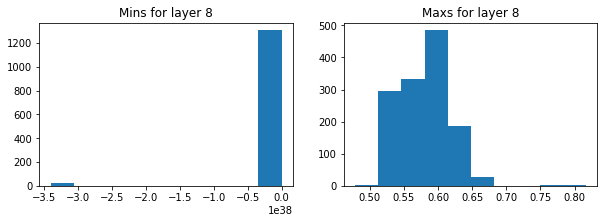

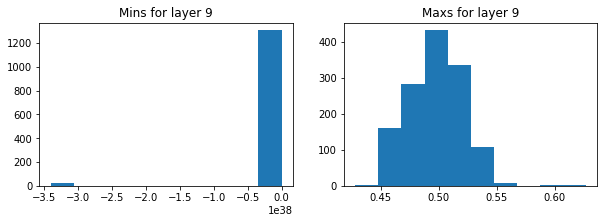

In [7]:
# distribution per layer

for i in range(10):
    mins = []
    maxs = []
    for j in range(feats.shape[0]):
        vals = feats[j][:, :, i].flatten()
        min_ = vals.min()
        max_ = vals.max()
    
        mins.append(min_)
        maxs.append(max_)

    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(mins)
    ax[0].set_title(f'Mins for layer {i}')
    ax[1].hist(maxs)
    ax[1].set_title(f'Maxs for layer {i}')
    plt.show()
    
    

In [8]:
# which have minimum values < - 1?
outliers = []
for i in feats:
    if np.min(i) < -1:
        outliers.append(i)

In [9]:
len(outliers)

24

In [10]:
# we trim outlier values to 0
feats_final = np.clip(feats, -1, 1)

In [11]:
feats_final.shape

(1329, 128, 128, 10)

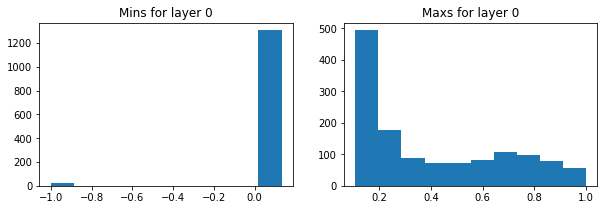

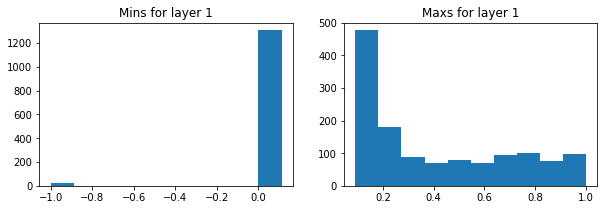

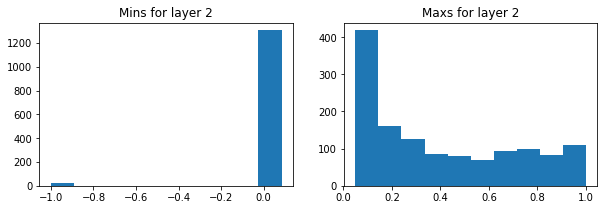

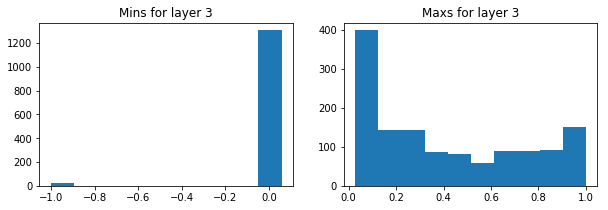

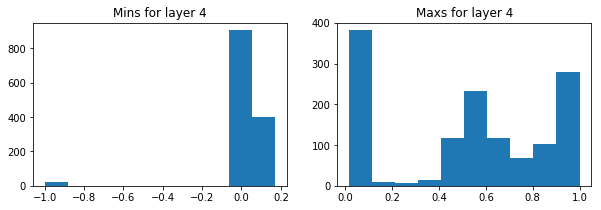

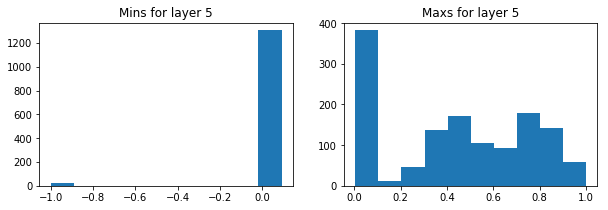

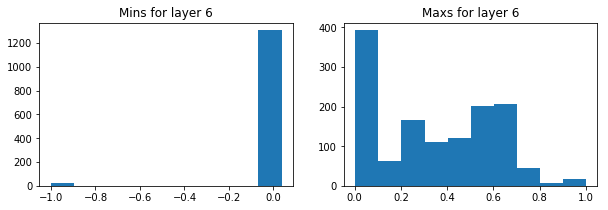

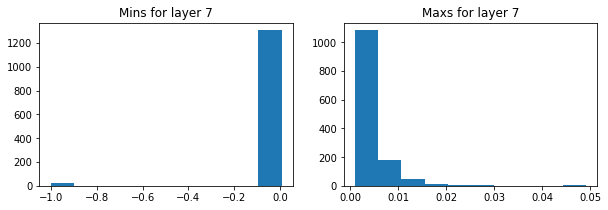

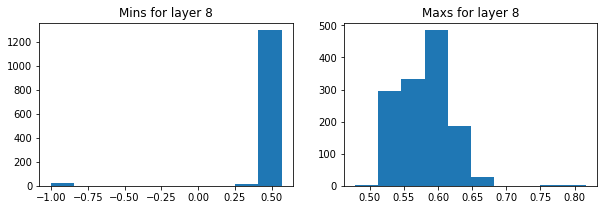

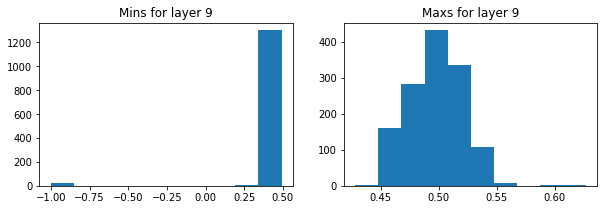

In [12]:
# distribution per layer

for i in range(10):
    mins = []
    maxs = []
    for j in range(feats_final.shape[0]):
        vals = feats_final[j][:, :, i].flatten()
        min_ = vals.min()
        max_ = vals.max()
    
        mins.append(min_)
        maxs.append(max_)

    f, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(mins)
    ax[0].set_title(f'Mins for layer {i}')
    ax[1].hist(maxs)
    ax[1].set_title(f'Maxs for layer {i}')
    plt.show()
    
    

In [56]:
## Compress labels

def compress_label(matrix):
    classes = [0, 1, 2, 4, 5, 6, 7, 15]

    new_array = []
    for i in range(8):
        layer = matrix[:, :, i]
        layer = np.round(layer) * classes[i]
        new_array.append(layer)
    
    new_array = np.array(new_array)
    new_array = np.swapaxes(new_array, 0, 2)
    new_array = np.max(new_array, axis=2)
    new_array = np.rot90(new_array, k=-1)
    new_array = np.fliplr(new_array)
    
    return new_array.astype(int)

# Test Prediction

In [14]:
from tensorflow.keras.models import load_model

In [17]:
unet_model = load_model('models/datos_unet_gen_sigmoid_2019_11_16_0.h5')

In [22]:
test_preds = unet_model.predict(feats_final)
test_preds.shape

(1329, 128, 128, 8)

In [57]:
test_preds2 = np.array([compress_label(i) for i in test_preds])

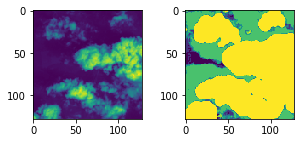

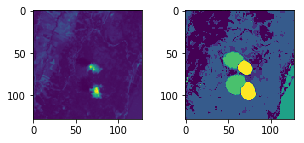

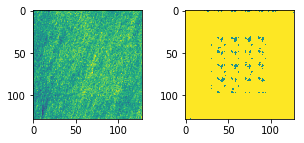

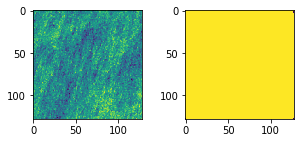

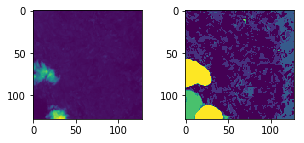

In [27]:
# predict
for i in np.random.choice(list(range(len(feats_final))), 5):

    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 2))

    test_feat = feats_final[i]

    # show one input
    axs[0].imshow(test_feat[:, :, 0])

    # predict sample with values from 0 to 1
    test_pred = test_preds2[i]

    axs[1].imshow(test_pred)

    plt.show()

## Submission File

In [35]:
# sample submission file
sample_sub = pd.read_csv("data/sample_submission_file.csv")
sample_sub.head()

,indexId,EncodedPixel_Pred
0,4230-20,NaN
1,4230-1,NaN
2,4230-2,NaN
3,4230-4,2 16382
4,4230-5,NaN


In [79]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode(mask):
    pixels = mask.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return rle_to_string(runs)

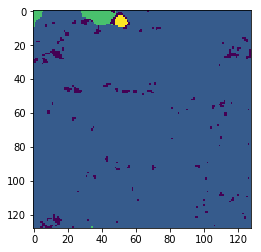

In [81]:
plt.imshow(test_preds2[i])

In [84]:
i = 2
encode = rle_to_string(rle_encode(test_preds2[i]))
encode

'2   5   2 9   1 8   4 9   1   6 8   1   1 2 9   5   1 5 7   1 9   1 7 7   1   1 7 9   2   2 5 7   5   2 8 6   2 0   3 1 0   7 5   3 9 0   2 4   4 3 3   2   4 3 8   1   5 1 3   4   5 4 4   1 6   5 6 2   5   5 6 8   7 3   6 4 4   2 7   6 7 5   1 2   6 8 9   7   7 6 9   2   7 9 3   1   7 9 7   5   8 0 3   1   8 1 5   2   8 2 4   1   8 9 7   1   9 0 8   2   9 2 0   2   9 2 5   4   9 3 3   9   9 4 5   8   9 5 4   7 1   1 0 2 6   6   1 0 3 3   2 2   1 0 5 7   5   1 0 6 8   3   1 0 7 2   1   1 0 8 0   2   1 1 5 3   1   1 1 6 0   1   1 1 9 1   1   1 2 0 3   4   1 2 0 8   1 1 1   1 3 2 0   1 4   1 3 3 6   1 5   1 3 5 2   1   1 3 5 6   9 0   1 4 4 8   2 4   1 4 7 3   8   1 4 8 2   7 3   1 5 5 6   1 8   1 5 7 7   2 2   1 6 0 1   8 3   1 6 8 6   1 5   1 7 0 4   1 0 8   1 8 1 4   2 5 1   2 0 6 6   1 0 6   2 1 7 4   1 9   2 1 9 5   1 0 6   2 3 0 3   4   2 3 0 9   1 0   2 3 2 1   1 0 9   2 4 3 1   1 6   2 4 4 8   9 6   2 5 4 5   2 6 1   2 8 0 7   2 7   2 8 3 5   9 9   2 9 3 5   2   2 9 3 9   1 7   2

In [67]:
ids = datos_test.iloc[:, 0].values
ids

array([5106, 1859, 2430, ..., 1660, 1392, 2992])

In [107]:
len(ids)

1329

In [85]:
from collections import Counter

Counter(test_preds2.flatten())

Counter({4: 7857083,
         0: 2445161,
         5: 1494243,
         6: 160964,
         2: 6557059,
         1: 587811,
         7: 2672015})

In [113]:
# Define a dictionary containing employee data
data = {'indexId':[],
        'EncodedPixel_RLE_Pred':[]}
  
df_solution=pd.DataFrame(data)

labels = [0, 1,  2,  4,  5,  6,  7, 15]

for i in range(len(test_preds2)):
    for label in labels:
        id_ = ids[i]
        layer = test_preds2[i] == label
        layer = layer.astype(int)
        rle = rle_encode(layer)
        if label == 0:
            data['indexId'] += [f'{id_}-20']
        else:
            data['indexId'] += [f'{id_}-{label}']
        data['EncodedPixel_RLE_Pred'] += [rle]

In [114]:
submission = pd.DataFrame.from_dict(data)

In [115]:
submission.head()

,indexId,EncodedPixel_RLE_Pred
0,5106-20,
1,5106-1,
2,5106-2,
3,5106-4,2 16382
4,5106-5,


In [116]:
submission.to_csv('submission.csv', index=False)

In [119]:
len(submission.indexId.values)/8

1329.0